# Cross validation and train test split example

This example notebook is still int works. But we are going to show an example for a regression problem and one example of a classification problem and how to implement these in datastack.ml.

What is still missing is an example on how to evaluate these prediction algorithms on the held out test data.

### Setting up the imports:

In [1]:
%matplotlib inline
import seaborn as sns
import pylab as plt
import pandas as pd
import numpy as np
import datastack
from datastack.dbs import rdb as rosetta

The code that we are demoing here:

In [2]:
import datastack.ml.cross_validation as cross_validation

We have to set up an RosettaDB connection and initialize it.

In [3]:
rdb = rosetta.RosettaDBMongo(host="rosetta.hli.io")
rdb.initialize(version="1439096023")

### Preparing a query for the experimental data

In [4]:
filters = {}
filters["pheno.HLI_CALC_Age_Sample_Taken"]     = (65, "<=")

keys    =  []
keys   +=  ["bamlist.BAM"]
keys   +=  ["pheno.HLI_CALC_Age_Sample_Taken"]
keys += ['pheno.face.hand_strength_left_m%i' % i for i in xrange(1,4)]
keys += ['pheno.face.hand_strength_right_m%i' % i for i in xrange(1,4)]
keys += ['facepheno.Sex']

studies = ['FACE']

### Preparing the KFoldPredefined object
Our internal cross validation object is derived from the sklearn.KFold and has the same derived functionalities, so if you are familar with that, you can use it as you are used to.

The object takes either an rdb connection (rdb) or a DataFrame (data) to query for the data specified in filters, keys and studies above.

By default it performs a 10 fold cross validation on 5/6th of the data. The split assignments are pre-determined by the 'qc.sample_id' of the corresponding row in Rosetta, thereby yielind consistent splits. Note that the splits are not exaxtly of equal size.
If you are using this object from a DataFrame, it needs to have the field 'qc.sample_id' specified to work.

In [5]:
#create KFoldPredefined object from rdb object
kfolds = cross_validation.KFoldPredefined(rdb=rdb, data=None, keys=keys, filters=filters, studies=studies)

Internally, KFoldPredefined instance stores the query in two member DataFrame named df and df_all.
If we look at the size of kfolds.df, we see that it only contains roughly 5/6th of the data, as mentioned above, whereas kfolds.df_all holds all the rows.

Note that none of the code demoed here uses the additional rows in kfold.df_all. This allows us to use these "fresh" data at a later point for validation purposes.

In [6]:
print "kfolds.df has %i rows and %i columns."% kfolds.df.shape
print "kfolds.df_all has %i rows and %i columns."% kfolds.df_all.shape
print "kfolds.df contains %.2f percent of the data available for training purposes." % (100.0 * kfolds.df.shape[0]/ kfolds.df_all.shape[0])
kfolds.df[0:3]

kfolds.df has 826 rows and 11 columns.
kfolds.df_all has 1014 rows and 11 columns.
kfolds.df contains 81.46 percent of the data available for training purposes.


,bamlist.BAM,facepheno.Sex,pheno.HLI_CALC_Age_Sample_Taken,pheno.face.hand_strength_left_m1,pheno.face.hand_strength_left_m2,pheno.face.hand_strength_left_m3,pheno.face.hand_strength_right_m1,pheno.face.hand_strength_right_m2,pheno.face.hand_strength_right_m3,qc.sample_key,ml.fold
55c6fddbc37a457d277112c0,hli-processed/processed/10042/isis_alignment_a...,Female,19,28,28,26,28,22,22,10042_187525491,2
55c6fddbc37a457d277112cc,hli-processed/processed/10072/isis_alignment_a...,Female,27,45,36,34,47,36,34,10072_187525469,0
55c6fddbc37a457d277112db,hli-processed/processed/10312/isis_alignment_a...,Male,20,48,46,44,50,40,36,10312_187522730,7


## Using kfolds to evaluate basic ML algorithms.

In the next section we are going to look at how to use the kfolds object to evaluate basic ML algorithms.
We have implemented a cross-validated ridge gression as a baseline model for regression and a cross-validated logistic regression as a baseline for classification, as well as some extremely naive baseline models described below.

If youa re familiar with how the train test splitting mechanism of scikit learn works, you can go ahead and use kfolds just the way you are used to.

However, we should always run these baseline models, to set any result of a potentially more complex models into perspective.

## Classification example
The first example is a classification example, predicting sex from hand strength.

### Cross validated (ridge) logistic regression
The code will run a ten fold cross validation on the training data.

In each of five cross validation loops, the model minimizes the training logistic loss given on the training data.
\begin{equation}
  \min_\beta \underbrace{\sum_{n=1}^{N}\sum_{c=1}^{C} - p_{true}(y_n=c) \cdot \log\left( \text{logit}^{-1}(X_n\beta) \right)}_{
  \text{LogLoss}} +\underbrace{\alpha \|\beta\|^2_2}_{\text{ridge}}
\end{equation}

This model has $\alpha$ as a parameter, which is chosen in an inner 5 fold cross validation loop. Given the best $\alpha$, the model is re-fitted using the complete training data.

### Setting up the glue code and evaluating the models
We need to provide a function that takes the dataframe in kfolds and extracts the input matrix $X$ as well as the output vector $y$ for the classification problem. Here we also perform a transformation to the original columns, as we use mean hand strength instead of hand strength alone.

In [7]:
#define xy_generator:
def get_meanhandstrength_and_sex(pheno_df):
    keys_left = ['pheno.face.hand_strength_left_m%i' % i for i in xrange(1,4)]
    keys_right = ['pheno.face.hand_strength_right_m%i' % i for i in xrange(1,4)]
    mean_left = pheno_df[keys_left].mean(1)
    mean_right = pheno_df[keys_right].mean(1)
    X = pd.DataFrame(data={"left": mean_left, "right": mean_right})
    return (X, pheno_df['facepheno.Sex']) 

The model is evaluated by creating an instance of EvaluationClassification that uses the xy_generator function and kfolds.

In [8]:
result_classification = cross_validation.EvaluationClassification(xy_generator=get_meanhandstrength_and_sex, kfolds=kfolds)

The simple baseline models are evaluated by creating an instance of EvaluationClassificationBaseline. Instead of xy_generator, the baseline class takes the column name of the target.

In [9]:
baseline_classification = cross_validation.EvaluationClassificationBaseline(target="facepheno.Sex", kfolds=kfolds)

### Evaluation metrics for classification
The model evaluates various metrics via 10 fold cross validation. We obtain the metrics below by calling the member function .get_metrics().

In [10]:
metrics_classification = result_classification.metrics_df
metrics_classification.append(baseline_classification.metrics_df)

,Model,Covariates,Error,LogLoss
0,LogisticRegression,"[left, right]",0.144068,0.371264
0,ModeClass ['Female'],[],0.412833,0.677873


#### Error rate (Error)
Smaller is better.
Error is the error rate, a number between 0 and 1, so
\begin{equation}
error = 1-accuracy.
\end{equation}
The naive baseline model predicts the majority class for all samples.
#### Logistic loss (LogLoss)
Smaller is better.
The Logistic loss is the cross entropy
\begin{equation}
  LogLoss = \sum_{n=1}^{N}\sum_{c=1}^{C} -p_{true}(y_n=c) \cdot log\left( p_{predicted}(y_n=c) \right),
\end{equation}
where $p_{true}(y_n=c)$ is either 1 for the true class or 0 otherwise and the predicted probabilities add up to 1 for all classes $c \in C$.
The naive baseline model predicts the class proportions as probabilities for all samples.

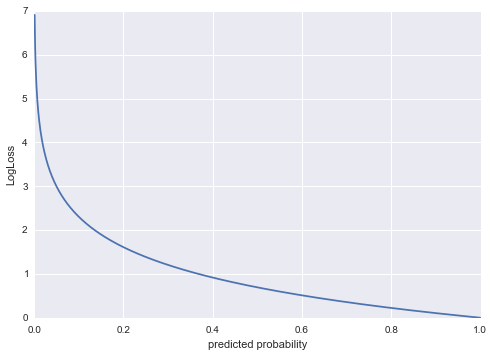

In [11]:
x = np.arange(0,1,0.001)
plt.plot(x,-np.log(x))
plt.xlabel('predicted probability')
plt.ylabel('LogLoss')

## Regression example
The first example is a regression example, predicting mean hand strength from sex.

### Cross validated (ridge) logistic regression
The code will run a ten fold cross validation on the training data.

In each of five cross validation loops, the model minimizes the training mean squared error loss given on the training data.
\begin{equation}
  \min_\beta \underbrace{\frac{1}{N}\sum_{n=1}^{N}(y_n=-X_n\beta)^2 }_{
  \text{MSE}} +\underbrace{\alpha \|\beta\|^2_2}_{\text{ridge}}
\end{equation}

This model has $\alpha$ as a parameter, which is chosen in an inner 5 fold cross validation loop. Given the best $\alpha$, the model is re-fitted using the complete training data.


### Setting up the glue code and evaluating the models
We need to provide a function that takes the dataframe in kfolds and extracts the input matrix $X$ as well as the output vector $y$ for the classification problem. Here we also perform a transformation to the original columns, as we predict mean hand strength instead of hand strength alone.

In [ ]:
#define xy_generator:
def get_sex_and_meanhandstrength(pheno_df):
    keys_both = ['pheno.face.hand_strength_left_m%i' % i for i in xrange(1,4)]
    keys_both += ['pheno.face.hand_strength_right_m%i' % i for i in xrange(1,4)]
    sex = np.ones_like(pheno_df['facepheno.Sex'].values,dtype=np.float)
    sex[pheno_df['facepheno.Sex'].values=='Female'] = -1.0
    sex = pd.DataFrame({'Sex': sex}, index=pheno_df.index)
    pheno_df['pheno.face.hand_strength_mean'] = pheno_df[keys_both].mean(1)
    return (sex, pheno_df['pheno.face.hand_strength_mean']) 

As in the classifiaciton case the model is evaluated by creating an instance of EvaluationClassification that uses the xy_generator function and kfolds.

In [ ]:
result_regression = cross_validation.EvaluationRegression(xy_generator=get_sex_and_meanhandstrength, kfolds=kfolds)

#### The naive baseline models

The simple baseline models are evaluated by creating an instance of EvaluationRegressionBaseline. Instead of xy_generator, the baseline class takes the column name of the target.

Note that we have cheated here, as target was no column in the original dataframe, but has been added in the call of get_sex_and_meanhandstrength above. Currently the baseline does not allow transformations. This will be fixed in a future version, allowing to instead provide an xy_generator to the baseline.

In [ ]:
baseline_regression = cross_validation.EvaluationRegressionBaseline(target='pheno.face.hand_strength_mean', kfolds=kfolds)

### Evaluation metrics for regression
The model evaluates various metrics via 10 fold cross validation. We obtain the metrics below by calling the member function .get_metrics().

In [ ]:
metrics_regression = result_regression.metrics_df
metrics_regression.append(baseline_regression.metrics_df)

#### Out of sample $R^2$
Larger is better.
\begin{equation}
R^2 = 1-\frac{\sum_{n=1}^N(y_n^{true}-y_n^{pred})^2}{\sum_{n=1}^N(y_n^{true}-\bar{y}^{true})^2}.
\end{equation}
Note that for out of sample predictions $R^2$ does not correspond to the squared correlation between predictions and true values. Also the value can easily be negative, either due to overfitting, outliers, or also just because the mean between train and test data is different. The latter generally makes $R^2$ slightly conservative.

#### Mean absolute error (MAE)
Smaller is better.
The MAE is less outlier sensitive than the other losses, but penalizes small deviations more heavily.
\begin{equation}
  MAE = \frac{1}{N}\sum_{n=1}^{N} |y_n^{true}-y_n^{pred}|,
\end{equation}
Note that the median on the test data always outperforms the mean on the test data for MAE.

#### Mean squared error (MAE)
Smaller is better.
\begin{equation}
  MSE = \frac{1}{N}\sum_{n=1}^{N} (y_n^{true}-y_n^{pred})^2,
\end{equation}
Note that the mean on the test data always outperforms the median on the test data for MAE.


In [ ]:
x = np.arange(-2.5,2.5,0.001)
plt.plot(x,np.absolute(x))
plt.plot(x,x**2.0)
plt.legend(['MAE','MSE'],4)
plt.xlabel('residual')
plt.ylabel('error')